STUDYING OIL PRICE AND CREATING A PREDICTING MODEL

Importing and cleaning data

In [17]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas_ta as ta
import seaborn as sns

db=yf.download("CL=F", start="2014-01-01", end="2023-01-01")
oilvol=yf.download("^OVX", start="2014-01-01", end="2023-01-01")
db=pd.merge(db,oilvol["Close"],left_on=db.index,right_on=oilvol.index,how="inner")
db.columns=["Date","open","high","low","Close","Adj Close","volume","volatility"]
db.set_index("Date",inplace=True)
db=db.drop(columns=["Adj Close"])
db["ema50"]=ta.ema(db["Close"],length=50)
db["ema200"]=ta.ema(db["Close"],length=200)
db["month"]=db.index.month
db["roc"]=(db["Close"]-db["Close"].shift(1))/db["Close"].shift(1)*100
db["tendayclose"]=db["Close"].shift(-5)

db["5dayclose"]=db["Close"].shift(-1)
db=db.dropna()
print(db.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 open       high        low      Close  volume  volatility  \
Date                                                                         
2014-10-16  81.059998  84.830002  79.779999  82.699997  424524   34.090000   
2014-10-17  83.180000  84.449997  82.440002  82.750000  174142   31.160000   
2014-10-20  83.129997  83.480003  81.550003  82.709999   83702   29.360001   
2014-10-21  82.760002  84.050003  82.290001  82.809998  297522   27.139999   
2014-10-22  82.550003  83.150002  80.220001  80.519997  352217   30.680000   

                ema50     ema200  month       roc  tendayclose  5dayclose  
Date                                                                       
2014-10-16  92.005424  98.847900     10  1.124967    82.089996  82.750000  
2014-10-17  91.642467  98.687722     10  0.060463    81.010002  82.709999  
2014-10-20 

Text(0.5, 1.0, 'oil price')

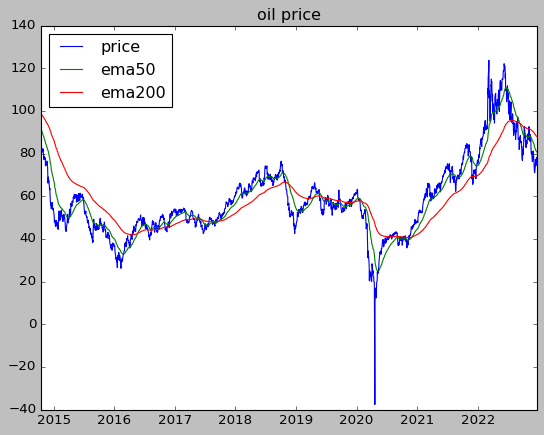

In [18]:
plt.plot(db.index, db["Close"])
plt.style.use("classic")
plt.plot(db.index,db["ema50"])
plt.plot(db.index,db["ema200"])
plt.legend(["price","ema50","ema200"],loc="upper left")
plt.title("oil price")

Text(0.5, 1.0, 'avg daily roc by month excluding 2020')

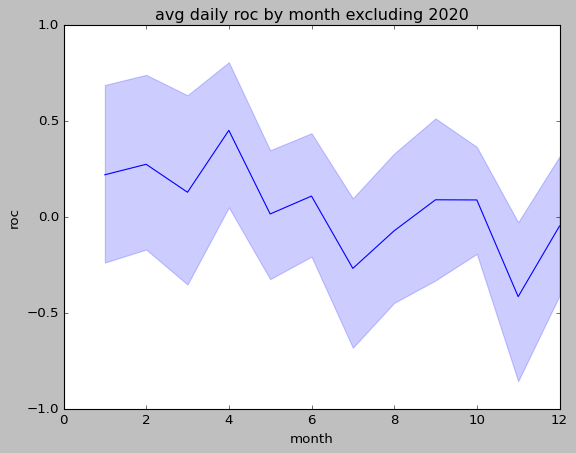

In [32]:
sns.lineplot(x="month",y="roc",data=db.loc[db.index.year!=2020])
plt.title("avg daily roc by month excluding 2020")


Text(0.5, 1.0, 'avg volatility per month excluding 2020')

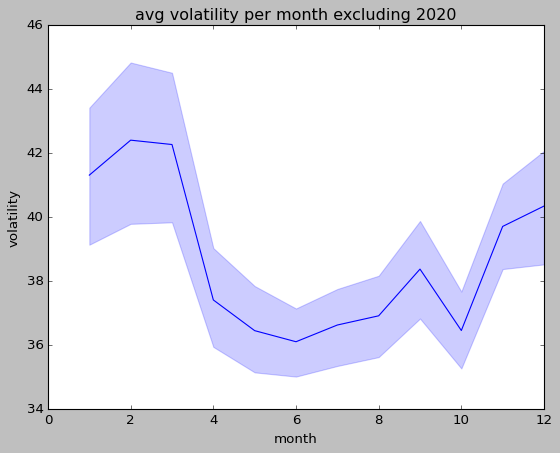

In [20]:
sns.lineplot(x="month",y="volatility",data=db.loc[db.index.year!=2020])
plt.title("avg volatility per month excluding 2020")

Text(0.5, 1.0, "price's correlations")

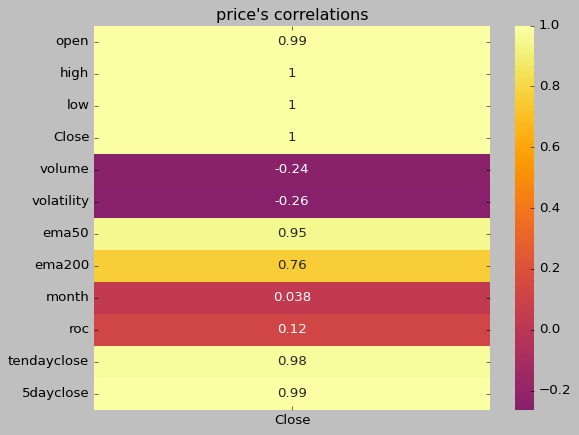

In [21]:
cor=db.corr()
sns.heatmap(cor[["Close"]],annot=True,cmap="inferno",center=0)
plt.title("price's correlations")
# print(db.head())

Scaling data

In [22]:
from sklearn.preprocessing import MinMaxScaler
scalernontarget=MinMaxScaler()
scalertarget=MinMaxScaler()
colonnenontarget=db[["open","high","low","Close","volume","volatility","ema50","ema200","month","roc"]].values.reshape(-1,10)
colonnetarget=db["5dayclose"].values.reshape(-1,1)
colonnenontarget=scalernontarget.fit_transform(colonnenontarget)
colonnetarget=scalertarget.fit_transform(colonnetarget)

print(colonnetarget)

[[0.74617246]
 [0.74592451]
 [0.74654435]
 ...
 [0.71852726]
 [0.71356846]
 [0.72639931]]


Creating the model

In [23]:
window=9
x=[]
y=[]
for i in range(len(colonnenontarget)-window):
    x.append(colonnenontarget[i:i+window])
    y.append(colonnetarget[i+window])
x=np.array(x)
y=np.array(y)
x=x.reshape(len(x),-1)
y=y.reshape(-1)
print(x[0])

[0.68556177 0.60902322 0.7454534  0.74586251 0.16407597 0.05281656
 0.77982398 1.         0.81818182 0.89367187 0.70085099 0.60577003
 0.76196389 0.74617246 0.05177267 0.04328159 0.77559594 0.99725348
 0.81818182 0.89057404 0.70049037 0.597466   0.75643971 0.74592451
 0.01120781 0.03742393 0.77151542 0.99452746 0.81818182 0.89025741
 0.69782201 0.60234572 0.76103284 0.74654435 0.10711204 0.03019948
 0.76764061 0.99184562 0.81818182 0.89074992 0.69630752 0.59464088
 0.74818447 0.73234984 0.13164427 0.04171955 0.76287163 0.98879977
 0.81818182 0.88235053 0.68094617 0.58796338 0.7471293  0.74208144
 0.13282031 0.04529923 0.75900688 0.98605208 0.81818182 0.89607231
 0.69198034 0.58436775 0.74905344 0.73538712 0.09589301 0.04363956
 0.75480033 0.98314747 0.81818182 0.88656946 0.68707626 0.57871758
 0.74334307 0.73532513 0.10164224 0.04744703 0.75075417 0.98027006
 0.81818182 0.89036215 0.68253279 0.58188515 0.74905344 0.73792847
 0.07506203 0.03986462 0.74705854 0.97749294 0.81818182 0.8919

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model=LinearRegression()
split=int(0.68*len(x))
xtrain,xtest=x[:split],x[split:]
ytrain,ytest=y[:split],y[split:]
model.fit(xtrain,ytrain)
pred=model.predict(xtest)
print(r2_score(ytest,pred))

0.9782011268838428


In [25]:
print(model.predict(xtest[0].reshape(-1,90)))
print(xtest[0].reshape(-1,90))

[0.4157238]
[[2.54146826e-01 1.01018750e-01 3.81416415e-01 3.85483179e-01
  1.47353058e-01 2.58420377e-01 1.91653731e-03 5.71796478e-02
  3.63636364e-01 9.49913542e-01 2.85013698e-01 1.06069688e-01
  3.90416482e-01 3.81950050e-01 1.44628251e-01 3.17387487e-01
  1.35201657e-03 5.37891526e-02 3.63636364e-01 8.83644140e-01
  2.74700701e-01 1.11719888e-01 3.92650984e-01 3.79222718e-01
  1.12825833e-01 3.01864702e-01 6.08633583e-04 5.03573236e-02
  3.63636364e-01 8.85060630e-01 2.69363907e-01 9.67382942e-02
  3.94637202e-01 3.86598907e-01 6.56945274e-02 2.63073963e-01
  4.38016964e-04 4.71626726e-02 3.63636364e-01 9.05103155e-01
  2.77585452e-01 1.01789233e-01 3.97182047e-01 3.82879819e-01
  5.42166999e-02 2.98935867e-01 0.00000000e+00 4.38974409e-02
  3.63636364e-01 8.83340387e-01 2.77585452e-01 1.07353822e-01
  4.00595859e-01 3.93045327e-01 6.89032956e-02 2.24543596e-01
  3.28342883e-04 4.09445059e-02 3.63636364e-01 9.10168592e-01
  2.83427075e-01 1.09237233e-01 4.04133824e-01 3.90008075e

In [26]:
window=10
x1=[]
y1=[]
for i in range(len(colonnenontarget)-window):
    x1.append(colonnenontarget[i:i+window])
    y1.append(colonnetarget[i+window])
x1=np.array(x1)
y1=np.array(y1)

In [27]:
split=int(0.7*len(x1))
x1train,x1test=x1[:split],x1[split:]
y1train,y1test=y1[:split],y1[split:]
print(x1train.shape)
print(x1train)


(1435, 10, 10)
[[[0.68556177 0.60902322 0.7454534  ... 1.         0.81818182 0.89367187]
  [0.70085099 0.60577003 0.76196389 ... 0.99725348 0.81818182 0.89057404]
  [0.70049037 0.597466   0.75643971 ... 0.99452746 0.81818182 0.89025741]
  ...
  [0.68707626 0.57871758 0.74334307 ... 0.98027006 0.81818182 0.89036215]
  [0.68253279 0.58188515 0.74905344 ... 0.97749294 0.81818182 0.89190703]
  [0.68909563 0.5923294  0.75575695 ... 0.97487653 0.81818182 0.89318596]]

 [[0.70085099 0.60577003 0.76196389 ... 0.99725348 0.81818182 0.89057404]
  [0.70049037 0.597466   0.75643971 ... 0.99452746 0.81818182 0.89025741]
  [0.69782201 0.60234572 0.76103284 ... 0.99184562 0.81818182 0.89074992]
  ...
  [0.68253279 0.58188515 0.74905344 ... 0.97749294 0.81818182 0.89190703]
  [0.68909563 0.5923294  0.75575695 ... 0.97487653 0.81818182 0.89318596]
  [0.69183613 0.58556627 0.75128794 ... 0.97210189 0.81818182 0.88657459]]

 [[0.70049037 0.597466   0.75643971 ... 0.99452746 0.81818182 0.89025741]
  [0.69

In [28]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
modelrn=Sequential()
modelrn.add(LSTM(units=50,activation="relu", input_shape=( 10, 10)))
modelrn.add(Dense(units=1))
modelrn.compile(optimizer="adam", loss="mean_squared_error")
modelrn.fit(x1train,y1train,epochs=10,batch_size=16)
predrn=modelrn.predict(x1test)

Epoch 1/10
90/90 [==============================] - 2s 5ms/step - loss: 0.0190
Epoch 2/10
90/90 [==============================] - 0s 5ms/step - loss: 5.1450e-04
Epoch 3/10
90/90 [==============================] - 0s 4ms/step - loss: 4.2209e-04
Epoch 4/10
90/90 [==============================] - 0s 5ms/step - loss: 3.8790e-04
Epoch 5/10
90/90 [==============================] - 0s 4ms/step - loss: 3.6119e-04
Epoch 6/10
90/90 [==============================] - 0s 4ms/step - loss: 3.4237e-04
Epoch 7/10
90/90 [==============================] - 0s 4ms/step - loss: 3.2940e-04
Epoch 8/10
90/90 [==============================] - 0s 4ms/step - loss: 3.1758e-04
Epoch 9/10
90/90 [==============================] - 0s 4ms/step - loss: 3.2251e-04
Epoch 10/10
20/20 [==============================] - 0s 3ms/step


Text(0.5, 1.0, '5 days prediction with lstm')

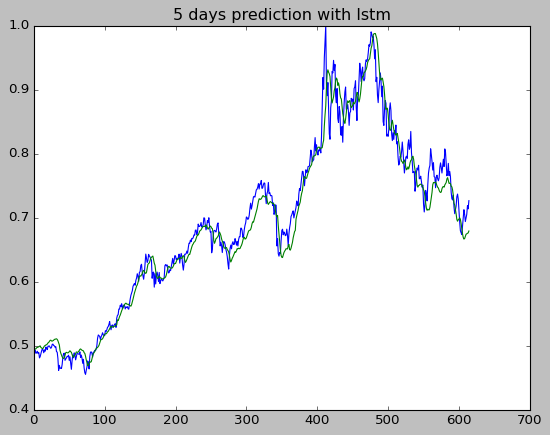

In [31]:
plt.plot(y1test)
plt.plot(predrn)
plt.title("5 days prediction with lstm")

Text(0.5, 1.0, '5 days prediction with linear regression')

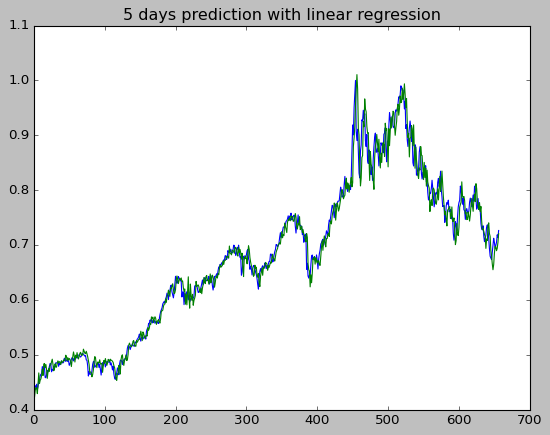

In [30]:
plt.plot(ytest)
plt.plot(pred)
plt.title("5 days prediction with linear regression")